<a href="https://colab.research.google.com/github/Servat0r/ISPR-Midterms-2023/blob/master/Midterm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm 1 ISPR 2023 - Assignment 6 - Salvatore Correnti (m. 584136)
In this assignment we will show the implementation and testing on different images of an image blob detector based on the `Laplacian of Gaussian` convolution filter.

## Initial imports
Before coding, we use a single cell for changing working directory to the one in which this notebook is contained and for all the imports for simplyfing reading.

In [ ]:
%cd ./ISPR-Midterms-2023

/content/ISPR-Midterms-2023


In [ ]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2 # for converting BGR -> grayscale
from scipy.signal import convolve2d as scipy_convolve2d # 2d-convolution operator
from scipy.ndimage import gaussian_laplace
from skimage.exposure import rescale_intensity as scipy_rescale_intensity
from PIL import Image
from typing import * # for function signatures

## Definition and Implementation of LoG
We first define the `Laplacian of Gaussian` operator as the sum of the diagonal elements of the Jacobian matrix of the Gaussian function:

$$g_{\sigma}(x, y) := \dfrac{1}{2\pi\sigma^2}e^{-\left(\dfrac{x^2 + y^2}{2\sigma^2}\right)}$$.

$$\nabla g_{\sigma}(x, y) = -\dfrac{g_{\sigma}(x,y)}{\sigma^2}\left[\begin{array}{c} x \\ y \end{array}\right]$$

$$\nabla^2g_{\sigma}(x,y) = \dfrac{\partial^2 g_{\sigma}}{\partial x^2} + \dfrac{\partial^2 g_{\sigma}}{\partial y^2} = \dfrac{e^{-\left(\dfrac{x^2 + y^2}{2\sigma^2}\right)}}{\pi\sigma^4}\left[\dfrac{x^2 + y^2}{2\sigma^2} - 1\right]\:\:(1)$$


As we can see in (1), the sign of $\nabla^2 g_{\sigma}$ is determined by the value of $x^2 + y^2$, which can be interpreted as the radius of a circle centered in $(0, 0)$ to which $(x, y)$ belongs, and in particular $\nabla^2 g_{\sigma}$ when this radius is equal to $\sigma\sqrt{2}$, for which in fact the $\nabla^2 g_{\sigma}$ used as convolutional filter has the maximum response.

Sometimes the Laplacian of Gaussian is used in its `normalized` form:

$$ \nabla^2_{norm}g_{\sigma}(x, y) := \sigma^2\nabla^2g_{\sigma}(x,y)$$

The normalized form has the effect to maintain a higher diversity in pixel values after the convolution.

Since we are operating with discrete values like images, we need to define a `kernel`, which is a matrix $M \in \mathbb{R^{(2n+1) \times (2n+1)}}$ such that $M_{n+1 \pm i, n+1 \pm j} = f(\pm i, \pm j)$ for a given function $f$.

In [ ]:
def log_filter(window_size: int, sigma: float = 1.0, normalized=False):
  """
  :param window_size: Size of the kernel window.
  :param sigma: Variance (sigma) of the LoG filter.
  """
  w1 = h1 = window_size // 2  # In case of odd window, will give 0 to central value
  w2 = h2 = window_size - w1
  x, y = np.arange(-w1, w2, 1), np.arange(-h1, h2, 1)
  mg = np.meshgrid(x, y)
  # Compute the (x^2+y^2/(2sigma^2)) matrix
  r = (np.square(mg[0][:, :]) + np.square(mg[1][:, :]))/(2 * sigma**2)
  # Now compute the exp(r) matrix
  gs = np.exp(-r)
  exponent = 2 if normalized else 4
  result = 1.0/(np.pi * sigma**exponent) * (gs * (r - 1.0)) # * for elementwise product
  return result.astype(np.float32)

An example of LoG matrix for a 3x3 kernel (both non-normalized and normalized):

In [ ]:
print("Non-normalized kernel: ")
print(log_filter(3, 2.0))
print("Normalized kernel: ")
print(log_filter(3, 2.0, True))

Non-normalized kernel: 
[[-0.01162031 -0.01536213 -0.01162031]
 [-0.01536213 -0.01989437 -0.01536213]
 [-0.01162031 -0.01536213 -0.01162031]]
Normalized kernel: 
[[-0.04648125 -0.06144851 -0.04648125]
 [-0.06144851 -0.07957747 -0.06144851]
 [-0.04648125 -0.06144851 -0.04648125]]


## Dataset
For performing convolutions we will use the following dataset:

http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip

Since its whole dimension is of about 125 MB, (by now) the whole dataset is stored in the same folder of this notebook.

We will now define some utilities for our task:

In [ ]:
def load_image(dir_path: str, file_name: str, to_grayscale=True):
  img = Image.open(os.path.join(dir_path, file_name))
  return img.convert('L') if to_grayscale else img

def get_image_array(arr: np.ndarray, show=False):
  image = Image.fromarray(arr, mode='L')
  if show:
    image.show()
  return image

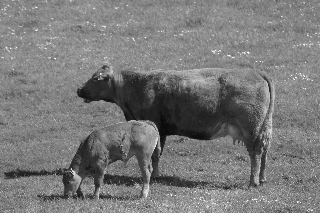

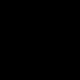

In [ ]:
img = load_image('MSRC_ObjCategImageDatabase_v1', '1_9_s.bmp')
img.show()

print()

# Just to check that get_image_array works correctly
black_image_arr = np.zeros((80, 80), np.uint8)
pil_black_image = get_image_array(black_image_arr, True)

After that, we define utility functions to use to compare the output of the convolution and of the `LoG` operator to assess correctness of our implementations.

In [ ]:
def cv2_convolver(src, kernel):
  """
  A wrapper function for `cv2.filter2D` to conform
  to the `convolver` argument of `convolve_image`.
  """
  out = cv2.filter2D(src, -1, kernel)
  return out

In [ ]:
def scipy_convolver(src, kernel):
  """
  A wrapper function for `scipy.signal.convolve2d` to
  conform to the `convolver` argument of `convolve_image`.
  """
  return scipy_convolve2d(src, kernel, mode='same')

In [ ]:
def log_scipy(img, sigma, radius=None):
  """
  LoG convolution as implemented by scipy in order
  to make comparisons.
  """
  img_arr = np.asarray(img, dtype=np.uint8)
  result = gaussian_laplace(img_arr, sigma, radius=(radius-1)//2)
  return result

Finally, we define a utility function to use with all convolvers so far to operate either with `Pillow` images or `numpy` arrays.

### Dealing with negative values
After having convolved the image with a given kernel, it may happen that there are negative values in the output, and since we need to operate with a grayscale image - i.e., unsigned 8-bit integer, we need to convert these values to negative ones.



1.   A standard way for doing this is by rescaling intensity, i.e. rescaling all the obtained values in the range $[0, 255]$ s.t. the "old" $0$ is mapped to a neutral gray (e.g. $128$), values $< 0$ in the range $[0, 127]$ and the others in the range $[129, 255]$. However, in this way we are not capable of comparing maxima between two different convolutions with two different $\sigma$, so we cannot do in this way;
2.   Another way is to simply take $\left\lfloor x\right\rfloor$ given $x$ in the output image and to take its value modulo $256$ in the range $[0, 255]$. We will follow this approach and we will also adopt this in our helper function in order to get this behavior for all convolvers.

In [ ]:
def convolve_image(
    image: Union[Image.Image, np.ndarray], kernel: np.ndarray,
    convolver: Callable[[np.ndarray, np.ndarray], np.ndarray]=scipy_convolve2d,
    rescale_intensity=False, to_uint8=True,
):
  """
  Given a grayscale PIL image, converts it to array and convolves
  it with the given kernel.
  :param image: PIL Image or numpy array to be convolved.
  :param kernel: numpy kernel to use for convolution.
  :param convolver: Function of the form (img, kernel) -> conv_img to use
  for performing convolution. Defaults to `scipy.signal.convolve2d`.
  :return: Convolved image as np.uint8 array.
  """
  if isinstance(image, Image.Image):
    img_arr = np.asarray(image).astype(np.float32)  # It is better to actually convolve with double values
  elif isinstance(image, np.ndarray):
    img_arr = image
  else:
    raise TypeError(f"Unknown input type '{type(image)}' for 'image' parameter.")
  conv_img = convolver(img_arr, kernel)
  if rescale_intensity:
    conv_img = scipy_rescale_intensity(conv_img, (0, 1))
    conv_img = 255 * conv_img
  if to_uint8:
    conv_img = conv_img.astype(np.uint8)
  return conv_img

Before proceeding, let's do a couple of comparisons between our `LoG` implementation and the one provided by `scipy.ndimage.gaussian_laplacian`, and between the non-normalized and the normalized filters.

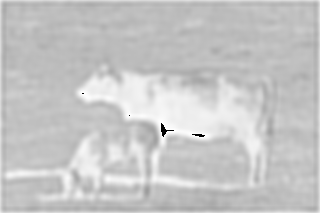

In [ ]:
# First normalized LoG
kernel = log_filter(15, 4, True)
conv_image = convolve_image(img, kernel, convolver=scipy_convolver)
pil_conv_image = get_image_array(conv_image, True)

We now compare with the LoG by `scipy`.

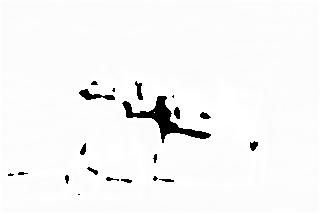

In [ ]:
# Then, non-normalized one (as the one used by scipy)
kernel = log_filter(15, 4)
conv_image = convolve_image(img, kernel, convolver=scipy_convolver)
pil_conv_image = get_image_array(conv_image, True)

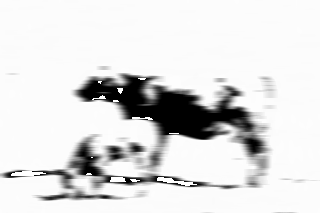

In [ ]:
conv_image = log_scipy(img, 4, 15)
pil_conv_image = get_image_array(conv_image, True)

## Convolution
We now manually define our convolver for 2D-images.

First, we must notice that the convolution is actually defined by pairwise multiplication **not** on the kernel matrix "untouched", but with a *swapped* version of it: given matrices $M \in \mathbb{R}^{m \times n}, K \in \mathbb{R}^{(2k+1) \times (2k+1)}$, it holds:

$$\left(M * K\right)_{ij} := \sum_{p = -k}^{k}{\sum_{q = -k}^{k}{M_{i+p, j+q}K_{k+1-p, k+1-q}}}$$

where for simplicity we define $M_{\alpha,\beta} = 0, K_{\alpha, \beta} = 0$ whenever $\alpha < 0 \vee \beta < 0$.

Our first step is then to define a function that applies that swapping:

In [ ]:
def swap_matrix(mat: np.ndarray):
  if len(mat.shape) != 2:
    raise ValueError("'mat' parameter must be a np.ndarray with shape of size 2")
  m, n = mat.shape[-2:]
  for i in range(m):
    mat[i, :] = mat[i, ::-1]
  for j in range(n):
    mat[:, j] = mat[::-1, j]
  return mat

Now just test that all works correctly:

In [ ]:
mat = np.random.randn(4, 4)
mat

array([[ 0.38502242,  0.66899397, -0.36061408, -0.72334743],
       [ 0.01096412,  0.33251286, -0.99876635,  0.73999925],
       [ 1.77000869, -0.3372732 , -1.75824628,  0.05248143],
       [-1.76145612,  0.45627186, -0.1863944 ,  0.47845791]])

In [ ]:
swap_matrix(mat)
mat

array([[ 0.47845791, -0.1863944 ,  0.45627186, -1.76145612],
       [ 0.05248143, -1.75824628, -0.3372732 ,  1.77000869],
       [ 0.73999925, -0.99876635,  0.33251286,  0.01096412],
       [-0.72334743, -0.36061408,  0.66899397,  0.38502242]])

We now define our convolution function. Before proceeding, it must be noted that for simplicity our function will implement **only** the *same* mode for convolutions: this is because we want to maintain the same dimension of the input image in the output one, and we want to center the kernel on the given point in the image at each step since we are calculating `LoG` for detecting blobs.

We now define some helper functions for code readability and for easier debugging:



In [ ]:
def get_offsets(k: int):
  """
  Given a kernel size k, returns the offsets on all directions
  for calculating the position of the kernel in the image.
  """
  left_width_offset = up_height_offset = k // 2 # According to our construction of kernel
  right_width_offset = down_height_offset = k - (k // 2) # Including center
  return left_width_offset, right_width_offset, up_height_offset, down_height_offset

In [ ]:
def get_kernel_indexes(i: int, j: int, m: int, n: int, k: int):
  """
  Given indexes of the current point in the image, size of the image
  and size of the kernel, calculates the indexes to use for selecting
  the sub-matrix of the kernel to use in current iteration.
  :param i: Row index of the current image point.
  :param j: Column index of the current image point.
  :param m: Row dimension of the image.
  :param n: Column dimension of the image.
  :param k: Dimension of the kernel.
  """
  left_width_offset, right_width_offset, up_height_offset, down_height_offset = get_offsets(k)
  kernel_column_start = max(0, left_width_offset - j)
  kernel_column_end = left_width_offset + min(right_width_offset, n - j)
  kernel_row_start = max(0, up_height_offset - i)
  kernel_row_end = up_height_offset + min(down_height_offset, m - i)
  return kernel_row_start, kernel_row_end, kernel_column_start, kernel_column_end

In [ ]:
def get_image_indexes(i, j, m, n, k):
  """
  Given indexes of the current point in the image, size of the image
  and size of the kernel, calculates the indexes to use for selecting
  the sub-matrix of the image to use in current iteration.
  :param i: Row index of the current image point.
  :param j: Column index of the current image point.
  :param m: Row dimension of the image.
  :param n: Column dimension of the image.
  :param k: Dimension of the kernel.
  """
  left_width_offset, right_width_offset, up_height_offset, down_height_offset = get_offsets(k)
  image_column_start = max(0, j - left_width_offset)
  image_column_end = min(n, j + right_width_offset)
  image_row_start = max(0, i - up_height_offset)
  image_row_end = min(m, i + down_height_offset)
  return image_row_start, image_row_end, image_column_start, image_column_end

Finally, here is our convolution function:

In [ ]:
def convolve2d(image: np.ndarray, kernel: np.ndarray):
  """
  Applies a 2d-convolution between the given image and
  the given kernel with padding.
  :param image: Image to convolve as numpy array.
  :param kernel: Kernel to use for convolution as 2d numpy array.
  :return: Convolved image as numpy array.
  """
  # First, copy kernel matrix to swap
  swap_kernel = kernel.copy()
  swap_matrix(swap_kernel)
  
  output = np.full(image.shape, 0.0, dtype=kernel.dtype)
  m, n = image.shape[-2:]  # m rows, n columns
  k = len(kernel)  # size of the kernel matrix
  for i in range(m):
    for j in range(n):
      # Extract submatrix from kernel for applying convolution
      kernel_row_start, kernel_row_end, kernel_column_start, kernel_column_end = get_kernel_indexes(i, j, m, n, k)
      kernel_submatrix = swap_kernel[kernel_row_start:kernel_row_end, kernel_column_start:kernel_column_end]
      # Now extract submatrix from image
      image_row_start, image_row_end, image_column_start, image_column_end = get_image_indexes(i, j, m, n, k)
      image_submatrix = image[image_row_start:image_row_end, image_column_start:image_column_end]
      # Now multiply the submatrices element-wise to get the current output item
      output[i, j] = np.sum(image_submatrix * kernel_submatrix)
  return output

Now let's test correctness of our implementation. First, visually compare with the above results, then calculate the difference in norm for that image and a randomly generated one:

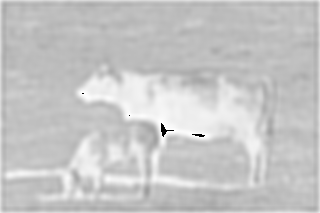

In [ ]:
kernel = log_filter(15, 4, True)
conv_image = convolve_image(img, kernel, convolver=convolve2d)
pil_conv_image = get_image_array(conv_image, True)

In [ ]:
kernel = log_filter(15, 4, True)
random_img = np.random.randint(0, 255, (200, 160)).astype(np.uint8)
scipy_conv_random_img = convolve_image(random_img, kernel, convolver=scipy_convolver)
own_conv_random_img = convolve_image(random_img, kernel, convolver=convolve2d)
print(np.linalg.norm(scipy_conv_random_img - own_conv_random_img))
print(np.sum(scipy_conv_random_img != own_conv_random_img))

0.0
0


In [ ]:
kernel = log_filter(15, 4, False)
random_img = np.random.randint(0, 255, (200, 160)).astype(np.uint8)
scipy_conv_random_img = convolve_image(random_img, kernel, convolver=scipy_convolver)
own_conv_random_img = convolve_image(random_img, kernel, convolver=convolve2d)
print(np.linalg.norm(scipy_conv_random_img - own_conv_random_img))
print(np.sum(scipy_conv_random_img != own_conv_random_img))

0.0
0


Now some time comparisons:

In [ ]:
%timeit convolve2d(np.asarray(img), kernel)
%timeit cv2.filter2D(np.asarray(img), -1, kernel)
%timeit scipy_convolve2d(np.asarray(img), kernel)

491 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
987 µs ± 133 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
33.4 ms ± 562 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Local Maxima detection
After having implemented and tested our 2D convolution, the subsequent step is to detect local maxima in the image produced by the convolution: this is because `LoG` filter has the maximum response when centered around a homogeneous region of radius $\approx \sigma\sqrt{2}$, hence if a given point $(x,y)$ is on the center of that region, its value will be a local maximum in the ball $\mathcal{B}\left((x, y), \sigma\sqrt{2}\right)$.

In our case, since we are operating in a discrete approximation of the continous space $\mathbb{R}^2$, we can simplify this detection by testing on a squared window of size $\left\lfloor{\sigma}\right\rfloor$: in fact, if $p_0 := (x_0, y_0)$ is the center of such a window $W(p_0)$, for any point $p := (x, y)$ it holds that $\|p - p_0\|^2 = (x-x_0)^2 + (y-y_0)^2 \leq 2\sigma^2$, hence $W(p_0) \subset \mathcal{B}\left((x, y), \sigma\sqrt{2}\right)$.

For capturing all local maxima, we need to cycle over the entire image: our next step will be to implement this algorithm.

In [ ]:
def local_maxima_finder(
    image: np.ndarray, sigma: float, kernel_size: int,
    thresholder: Callable[[np.ndarray], Any] = lambda x: x.mean().item()-1,
    result: np.ndarray = None,
):
  """
  :param image: numpy array of the image.
  :param sigma: sigma value for `log_filter`.
  :param kernel_size: Size of the kernel used for convolution. 
  :return: A numpy matrix which contains -1 for all elements
  which are not local maxima and the pixel value for all local
  maxima. If `result` is not None, stores the computed values
  in the given array.
  """
  if result is None:
    result = np.full(image.shape, -1, dtype=np.intc)
  radius = math.floor(sigma)
  if radius <= 1.0:
    raise ValueError("Too small radius, all points in the image will be local maxima!")
  m, n = image.shape[-2:]
  internal_image = image.copy().astype(np.intc) # Do not affect the original image!
  for i in range(radius, m - radius):
    for j in range(radius, n - radius):
      row_start, row_end, column_start, column_end = get_image_indexes(i, j, m, n, radius)
      max_value = np.max(image[row_start:row_end, column_start:column_end]).item()
      if internal_image[i, j] >= max_value:
        result[i, j] = internal_image[i, j]
        # Filtering for identical values
        for p in range(row_start, row_end):
          for q in range(column_start, column_end):
            if internal_image[p, q] >= max_value:
              internal_image[p, q] = -1  # Will not take it also as maximum (almost)
  threshold_value = thresholder(result[result > -1])
  result[result < threshold_value] = -1
  return result

An example:

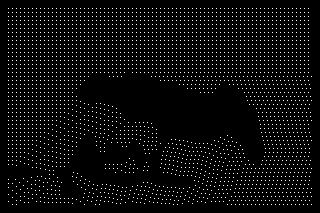

Number of local maxima found: 2923 (4.2884% of the pixels in the image)


In [ ]:
sigma = 8
kernel_size = 15
kernel = log_filter(kernel_size, sigma)
conv_image = convolve_image(img, kernel, convolver=convolve2d)
result = local_maxima_finder(conv_image, sigma, kernel_size)
result[result == -1] = 0
result = result.astype(np.uint8)
pil_conv_image = get_image_array(result, True)
num_local_maxima = len(result[result > 0])
print(f"Number of local maxima found: {num_local_maxima} ({100 * num_local_maxima / np.prod(conv_image.shape):.4f}% of the pixels in the image)")

## Maximizing over the scaling dimension
After having found the local maxima in the so-called *`spatial dimension`*, to complete the blob detection we need to compare the results for different values of $\sigma$, keeping only the best one for each pixel across *all* of them: this is called maximization over the *`scaling dimension`*.

We will use different values of $\sigma$, e.g. the set $\{2^n\:|\:0 \leq n \leq C\}$ for some constant $C$. Varying across a wide range for $\sigma$ is important to detect both small and large blobs.

In [ ]:
def total_maxima_finder(
    image: np.ndarray, sigmas: list[float], kernel_size: int,
    normalize_kernels=True, convolver=scipy_convolver,
    thresholder=lambda x: x.mean().item()
):
  points = []
  # Sort sigmas in reverse order to make sure that when using np.argmax()
  # we take the result with the highest sigma value (hence the highest radius)
  sigmas = sorted(sigmas, reverse=True)
  m, n = image.shape[-2:]
  results = np.full((len(sigmas), m, n), -1, dtype=np.intc)
  for i in range(len(sigmas)):
    sigma = sigmas[i]
    kernel = log_filter(kernel_size, sigma, normalize_kernels)
    conv_image = convolve_image(image, kernel, convolver, to_uint8=True)
    local_maxima_finder(conv_image, sigma, kernel_size, thresholder, results[i])
  # Now we have a len(sigmas) x m x n array that we can use to calculate
  # best points
  maximums = np.argmax(results, axis=0)
  # Now results[maximums[i, j], i, j] == {
  #   -1 if (i, j) is NEVER a maximum;
  #   k(i, j) > -1 otherwise
  # }
  for i in range(m):
    for j in range(n):
      if results[maximums[i, j], i, j] > -1:
        points.append((i, j, sigmas[maximums[i, j]]))
  return points

We can now define a function to plot the results over the image:

In [ ]:
def plot_results(
    images: Union[Image.Image, list[Image.Image]],
    points: Union[list[tuple], list[list[tuple]]],
    show=True, figsize_scale_factor=1,
  ):
  if isinstance(images, Image.Image):
    images = [images]
  if isinstance(points[0], tuple):
    points = [points]
  n = len(images)
  # (6.4, 4.8) are the default values for figsize in matplotlib
  figsize = (figsize_scale_factor * 6.4, figsize_scale_factor * 4.8)
  fig, ax = plt.subplots(1, n, figsize=figsize)
  if n == 1:
    ax = np.array([ax])  # Uniforming with the case of n > 1
  for i in range(len(images)):
    ax[i].imshow(images[i], interpolation='nearest', cmap='gray')
    for blob in points[i]:
      y, x, r = blob
      c = plt.Circle((x, y), r*math.sqrt(2), color='red', linewidth=1.5, fill=False)
      ax[i].add_patch(c)
    ax[i].plot()
    
  if show:
    plt.show()

And finally an example:

108


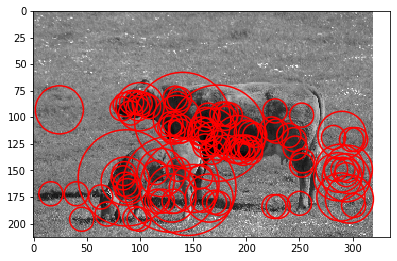

In [ ]:
sigmas = [32, 16, 8]
img_array = np.asarray(img)
m, n = img_array.shape[-2:]
kernel_size = 33
points = total_maxima_finder(img_array, sigmas, kernel_size, convolver=convolve2d)
print(len(points))
plot_results(img, points)

### Dealing with overlapping blobs

As we can see, there are many overlapping blobs, either one inside another or having a large overlapping zone: this is because the same blob may have been detected by multiple points inside it in different scales, and we have not yet performed any check between points coming from *different* scales.

One simple way to do this is to compare the distance $d$ between two blobs $\mathcal{B_1}$ and $\mathcal{B_2}$ with the values of the radiuses of the blobs $r_1$ and $r_2$. In particular:

- if $d >= r_1 + r_2$, then the two circles do not overlap;
- if $d <= |r_1 - r_2|$, then this means that the blob with radius $\min(r1, r2)$ is inside the other, so it can be eliminated;
- if $|r1 - r2| < d < r1 + r2$, then we are in an intermediate case.

As a consequence of this, we can say that the area of the overlapping between $\mathcal{B_1}$ and $\mathcal{B_2}$ with respect to the area of the smallest blob is $0$ in the first case, $1$ in the second and in $(0, 1)$ in the third, and we can give a roughly estimate of that area in this last case by considering a linear relation between $d$ and that value, i.e. we can consider an $f(d, r_1, r_2) \in [0, 1]$ of the form $\alpha d + \beta$ that gives the following:

$$\begin{cases} \alpha |r1 - r2| + \beta = 1 \\ \alpha (r1 + r2) + \beta = 0\end{cases}$$

from which we get:

$$ \begin{cases} \alpha = - \dfrac{1}{r1 + r2 - |r1 - r2|} \\ \beta = \dfrac{r_1 + r_2}{r1 + r2 - |r1 - r2|}\end{cases}$$

and finally:

$$ f(d, r_1, r_2) = \begin{cases} 1 & (\alpha d + \beta \geq 1) \\ 0 & (\alpha d + \beta \leq 0) \\ \alpha d + \beta & \text{otherwise}\end{cases}$$

In [ ]:
def blob_overlap(blob1, blob2):
  """
  Implements the above function for estimating
  overlapping area between two circles.
  """
  if (blob1 is None) or (blob2 is None):
    return 0
  # radiuses of two blobs
  r1 = blob1[-1]
  r2 = blob2[-1]
  
  d = math.sqrt((blob1[0] - blob2[0])**2 + (blob1[1] - blob2[1])**2)
  alpha = - 1 /(r1 + r2 - abs(r1 - r2))
  beta = (r1 + r2)/(r1 + r2 - abs(r1 - r2))
  f = alpha * d + beta
  if f >= 1:
    return 1
  elif f <= 0:
    return 0
  else:
    return f

We can use this information in several ways:


1.   One is to just discard the smallest cirlce, assuming that the largest one is capturing an actual blob in the image
2.   The other is to calculate the variance (e.g. in the RGB image) between all the pixel values in the window associated to each circle and discard the circle with the highest one, since it is probably capturing also areas that do not belong to the actual blob.

The first technique may overestimate the dimension of a blob, while the second one may underestimate it, so we may try both.



In [ ]:
def remove_redundancies(
    points: list, overlap_threshold = 0.5,
    mode='largest', source_image=None,
):
  for i in range(len(points)):
    blob1 = points[i]
    if blob1 is None: continue
    for j in range(i+1, len(points)):
      blob2 = points[j]
      if blob_overlap(blob1, blob2) >= overlap_threshold:
        if mode == 'largest':
          if blob1[-1] >= blob2[-1]:
            points[j] = None
          else:
            points[i] = None
            break
        elif mode == 'variance':
          if source_image is None:
            raise ValueError(f"Cannot have source_image=None when mode == '{mode}'")
          else:
            m, n = source_image.shape[-2:]
            # Calculate variances
            row_start_index, row_end_index, column_start_index, column_end_index = \
            get_image_indexes(blob1[0], blob1[1], m, n, blob1[2])
            var1 = np.var(
                source_image[row_start_index:row_end_index, column_start_index:column_end_index]
            )

            row_start_index, row_end_index, column_start_index, column_end_index = \
            get_image_indexes(blob2[0], blob2[1], m, n, blob2[2])
            var2 = np.var(
                source_image[row_start_index:row_end_index, column_start_index:column_end_index]
            )

            if var1 >= var2:
              points[i] = None
              break
            else:
              points[j] = None
        else:
          raise ValueError(f"Unknown mode {mode}")
          
  points = [point for point in points if point is not None]
  return points

Now let's show another example:

Initial #points = 108; reduced to 26 (mode 1), 44 (mode 2)


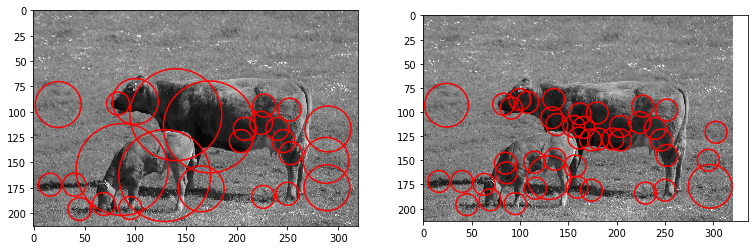

Elapsed time: 4.088968869000155 seconds


In [ ]:
import time
crt = time.perf_counter()
sigmas = [32, 16, 8]
img_array = np.asarray(img)
m, n = img_array.shape[-2:]
kernel_size = 33
points1 = total_maxima_finder(
    img_array, sigmas, kernel_size, convolver=convolve2d
)
points2 = [point for point in points1]  # Make a copy for comparison of the two modes

init_len = len(points1)
points1 = remove_redundancies(points1)
p1_final_len = len(points1)
points2 = remove_redundancies(points2, mode='variance', source_image=img_array)
p2_final_len = len(points2)
print(
  f"Initial #points = {init_len}; reduced to {p1_final_len} (mode 1), " \
  f"{p2_final_len} (mode 2)"
)
plot_results([img, img], [points1, points2], figsize_scale_factor=2)
crt = time.perf_counter() - crt
print(f"Elapsed time: {crt} seconds")

As we can see, the result is way better than before, and in particular with a quite large kernel (`kernel_size` = $33$), it has captured most of the body of the cows together with many smaller blobs on the ground given for instance by the shadows. In particular, most of the blobs that were overlapping before have been eliminated.

As one could expect, with `"variance"` mode the largest circles have been eliminated and the remaining ones are focused on smaller parts of the body of the cows. It is worth noting, however, that the two images share a subset of circles, that in fact are particularly fitting the actual colors in the image (e.g. for the shadows or the body of the biggest cow).

## Putting it all together

Finally, for doing extensive experimentation it is convenient to wrap all the code written above into a single function taking the target image, the kernel sizes, the sigma values and some other control parameters and printing the final result.

In [39]:
def experiment(
    dir_path: str, file_name: str, kernel_sizes: list[int],
    sigmas: list[float], normalized_kernel: bool = False,
    thresholder=lambda x: x.mean().item() - 1,
    blob_overlap_thresholder=0.5, convolver=convolve2d,
    figsize_scale_factor=1, remove_redundancies_mode='largest',
):
  exp_time = time.perf_counter()
  rgb_image = load_image(dir_path, file_name, to_grayscale=False)
  gray_image = load_image(dir_path, file_name, to_grayscale=True)
  gray_image_array = np.asarray(gray_image, dtype=np.uint8)
  n = len(kernel_sizes)
  all_points = [[]]
  images = [rgb_image]
  for kernel_size in kernel_sizes:
    experiment_string = f"Experiment<kernel_size = {kernel_size}, " \
    f"normalized = {normalized_kernel}, blob_overlap_thresholder = " \
    f"{blob_overlap_thresholder}, remove_redundancies_mode = " \
    f"{remove_redundancies_mode}>"
    crt = time.perf_counter()
    points = total_maxima_finder(
      gray_image_array, sigmas, kernel_size,
      normalize_kernels=normalized_kernel,
      convolver=convolver, thresholder=thresholder,
    )
    init_len = len(points)
    points = remove_redundancies(
        points, mode=remove_redundancies_mode, source_image=gray_image_array
    )
    final_len = len(points)
    crt = time.perf_counter() - crt
    print(f"{experiment_string}:\n\t<Initial_#points = {init_len}, " \
          f"final_#points = {final_len}," \
          f"elapsed time: {crt:.4f} seconds>")
    images.append(rgb_image)
    all_points.append(points)
  exp_time = time.perf_counter() - exp_time
  plot_results(images, all_points, figsize_scale_factor=figsize_scale_factor)
  print(f"Experiment ended in {exp_time:.4f} seconds")


### Experiments
We will now do some experiments to showcase differences between different kernel sizes, different sigma values and different images. The dataset is divided into $8$ different categories, representing respectively *animals*, *trees*, *houses*, *airplanes*, *other animals*, *faces*, *cars* and *bycicles*. For each of the categories  `animals`, `trees`, `faces` and `bycicles` we will take an image and perform the following:

- `kernel_sizes`: $\{33, 17, 5\}$;
- `sigmas`: $\{[32, 16, 8]\}$;
- `normalized_kernel`: $\{\texttt{True}, \texttt{False}\}$;
- `blob_overlap_thresholder`: $\{0.5\}$;
- `mode`: $\{\texttt{"largest"}, \texttt{"variance"}\}$;

for a total of $48$ tests.


Experiment<kernel_size = 33, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 1650, final_#points = 58,elapsed time: 5.0325 seconds>
Experiment<kernel_size = 17, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 3091, final_#points = 143,elapsed time: 4.0395 seconds>
Experiment<kernel_size = 5, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 3800, final_#points = 72,elapsed time: 3.7080 seconds>


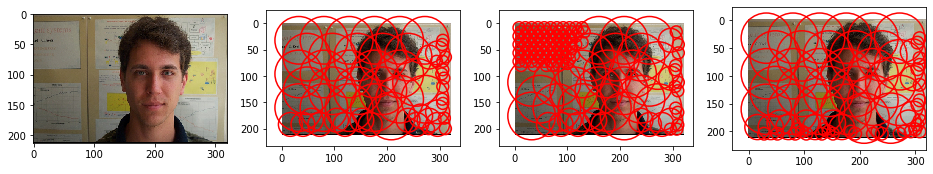

Experiment ended in 12.7856 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 1650, final_#points = 118,elapsed time: 5.2013 seconds>
Experiment<kernel_size = 17, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 3091, final_#points = 233,elapsed time: 4.2713 seconds>
Experiment<kernel_size = 5, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 3800, final_#points = 259,elapsed time: 5.5207 seconds>


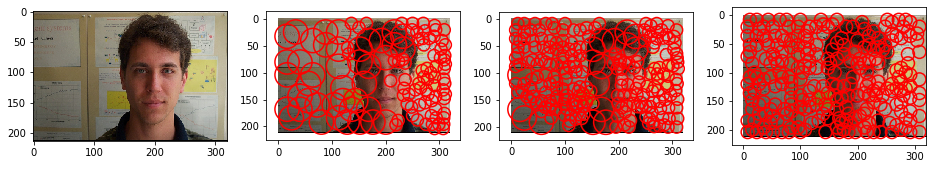

Experiment ended in 14.9948 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 271, final_#points = 84,elapsed time: 3.0534 seconds>
Experiment<kernel_size = 17, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 248, final_#points = 27,elapsed time: 2.8881 seconds>
Experiment<kernel_size = 5, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 1663, final_#points = 85,elapsed time: 4.4591 seconds>


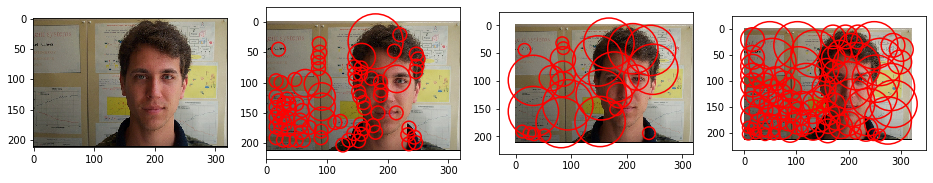

Experiment ended in 10.4022 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 271, final_#points = 73,elapsed time: 3.1018 seconds>
Experiment<kernel_size = 17, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 248, final_#points = 51,elapsed time: 2.9090 seconds>
Experiment<kernel_size = 5, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 1663, final_#points = 194,elapsed time: 3.9921 seconds>


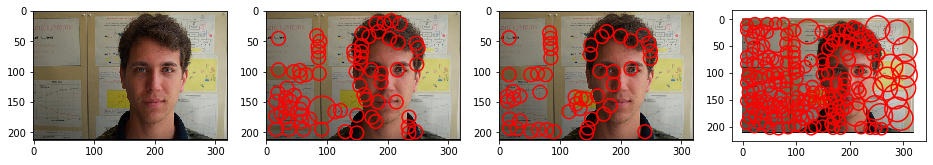

Experiment ended in 10.0068 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 1788, final_#points = 78,elapsed time: 3.9862 seconds>
Experiment<kernel_size = 17, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 3497, final_#points = 102,elapsed time: 3.8812 seconds>
Experiment<kernel_size = 5, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 3800, final_#points = 72,elapsed time: 4.8929 seconds>


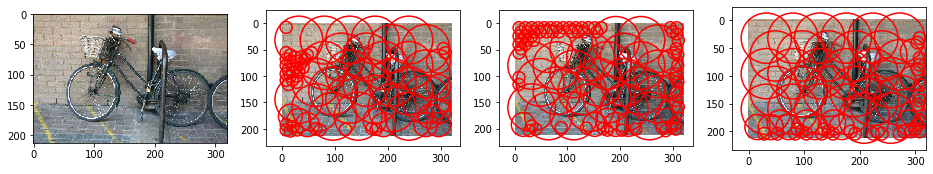

Experiment ended in 12.7628 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 1788, final_#points = 152,elapsed time: 4.1255 seconds>
Experiment<kernel_size = 17, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 3497, final_#points = 279,elapsed time: 4.3886 seconds>
Experiment<kernel_size = 5, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 3800, final_#points = 285,elapsed time: 5.5448 seconds>


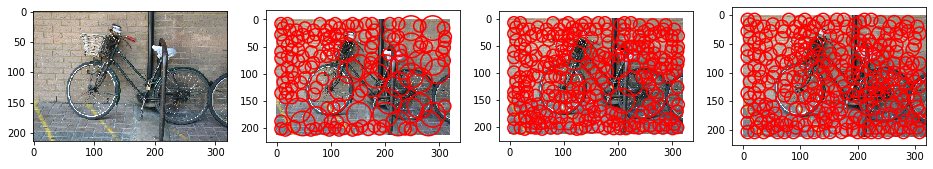

Experiment ended in 14.0606 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 152, final_#points = 46,elapsed time: 3.3494 seconds>
Experiment<kernel_size = 17, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 185, final_#points = 21,elapsed time: 4.1214 seconds>
Experiment<kernel_size = 5, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 1064, final_#points = 62,elapsed time: 3.1691 seconds>


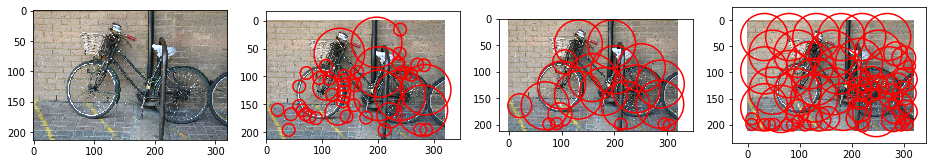

Experiment ended in 10.6436 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 152, final_#points = 57,elapsed time: 3.1367 seconds>
Experiment<kernel_size = 17, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 185, final_#points = 55,elapsed time: 3.0390 seconds>
Experiment<kernel_size = 5, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 1064, final_#points = 162,elapsed time: 4.3182 seconds>


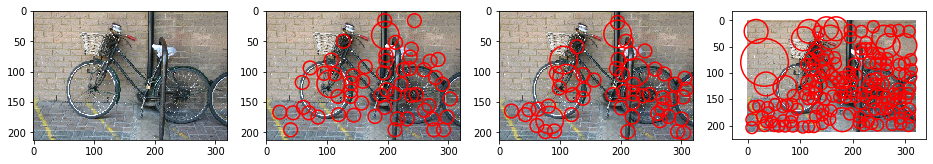

Experiment ended in 10.4960 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 1132, final_#points = 64,elapsed time: 3.9837 seconds>
Experiment<kernel_size = 17, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 3487, final_#points = 232,elapsed time: 5.3404 seconds>
Experiment<kernel_size = 5, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 3800, final_#points = 72,elapsed time: 3.8683 seconds>


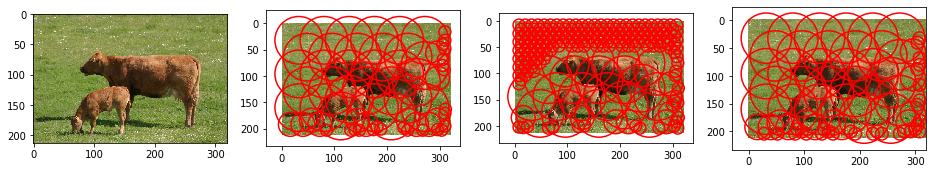

Experiment ended in 13.1946 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 1132, final_#points = 112,elapsed time: 4.1245 seconds>
Experiment<kernel_size = 17, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 3487, final_#points = 320,elapsed time: 5.6607 seconds>
Experiment<kernel_size = 5, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 3800, final_#points = 312,elapsed time: 4.4488 seconds>


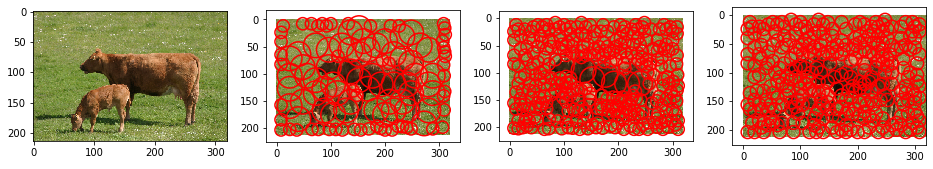

Experiment ended in 14.2357 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 115, final_#points = 28,elapsed time: 4.6614 seconds>
Experiment<kernel_size = 17, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 165, final_#points = 28,elapsed time: 2.9383 seconds>
Experiment<kernel_size = 5, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 885, final_#points = 39,elapsed time: 4.8875 seconds>


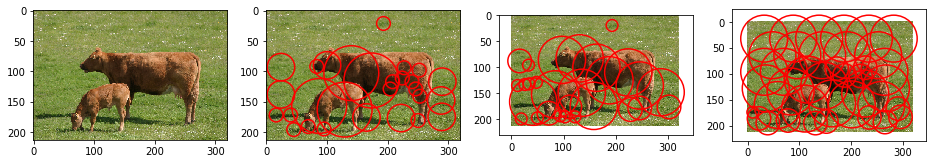

Experiment ended in 12.4918 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 115, final_#points = 46,elapsed time: 4.0244 seconds>
Experiment<kernel_size = 17, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 165, final_#points = 52,elapsed time: 2.9762 seconds>
Experiment<kernel_size = 5, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 885, final_#points = 119,elapsed time: 3.2454 seconds>


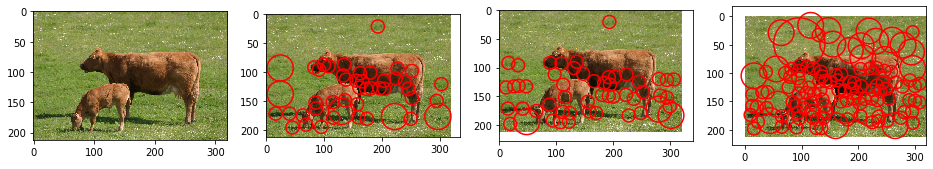

Experiment ended in 10.2470 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 2201, final_#points = 117,elapsed time: 5.2502 seconds>
Experiment<kernel_size = 17, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 3364, final_#points = 63,elapsed time: 3.7067 seconds>
Experiment<kernel_size = 5, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 3800, final_#points = 60,elapsed time: 3.7510 seconds>


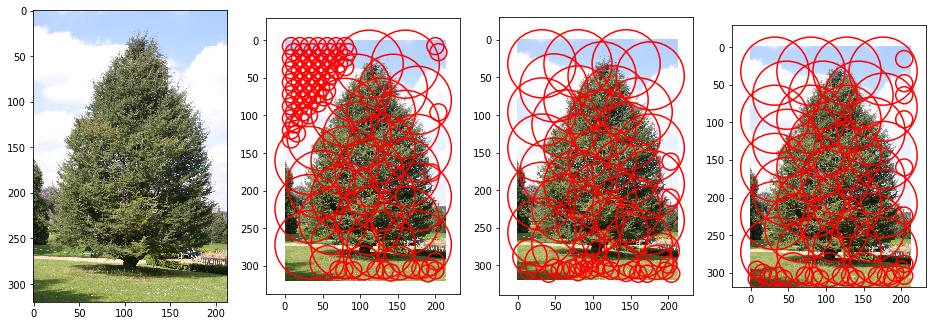

Experiment ended in 12.7103 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 2201, final_#points = 156,elapsed time: 5.2713 seconds>
Experiment<kernel_size = 17, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 3364, final_#points = 243,elapsed time: 4.2008 seconds>
Experiment<kernel_size = 5, normalized = False, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 3800, final_#points = 278,elapsed time: 5.2309 seconds>


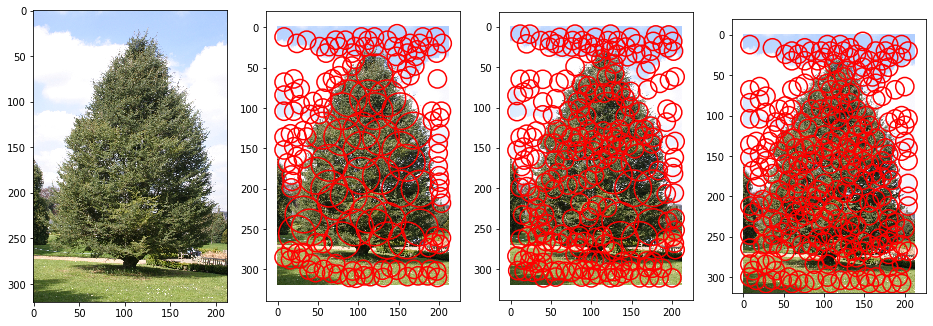

Experiment ended in 14.7109 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 115, final_#points = 34,elapsed time: 3.0827 seconds>
Experiment<kernel_size = 17, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 162, final_#points = 20,elapsed time: 2.8784 seconds>
Experiment<kernel_size = 5, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = largest>:
	<Initial_#points = 849, final_#points = 55,elapsed time: 4.0382 seconds>


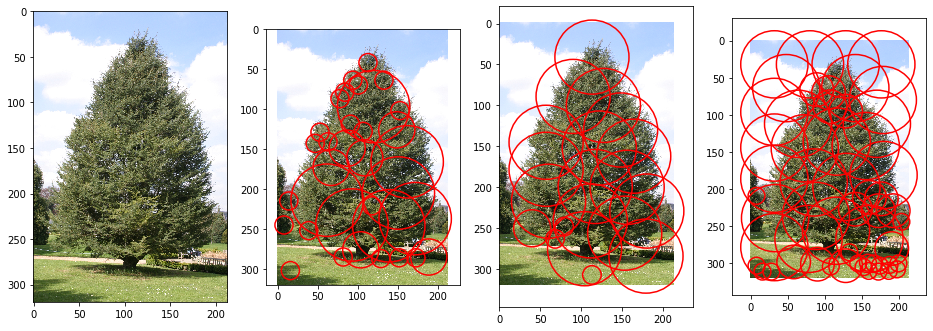

Experiment ended in 10.0043 seconds
________________________________________________________________________________________________________________________
Experiment<kernel_size = 33, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 115, final_#points = 54,elapsed time: 3.1199 seconds>
Experiment<kernel_size = 17, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 162, final_#points = 56,elapsed time: 2.8977 seconds>
Experiment<kernel_size = 5, normalized = True, blob_overlap_thresholder = 0.5, remove_redundancies_mode = variance>:
	<Initial_#points = 849, final_#points = 176,elapsed time: 3.2605 seconds>


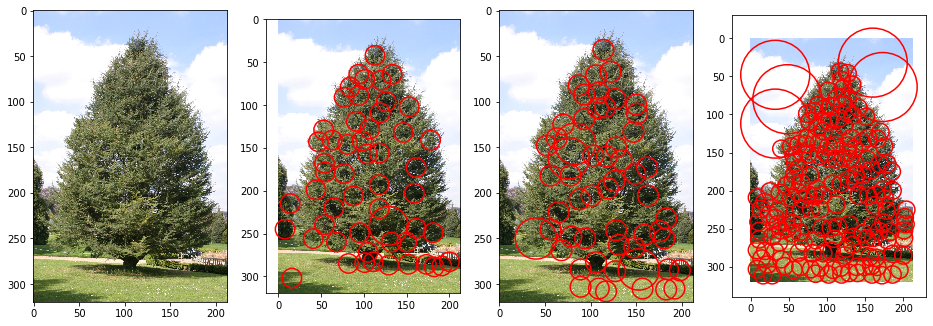

Experiment ended in 9.2820 seconds
________________________________________________________________________________________________________________________


In [40]:
images_file_names = {'1_9_s.bmp', '2_6_s.bmp', '6_4_s.bmp', '8_9_s.bmp'}
directory = 'MSRC_ObjCategImageDatabase_v1'
kernel_sizes = [33, 17, 5]
sigmas = [32, 16, 8]
blob_overlap_thresholders = {0.5}
normalized_kernel = {False, True}
modes = {'largest', 'variance'}
for image_file_name in images_file_names:
  for normalize_kernel in normalized_kernel:
    for blob_ths in blob_overlap_thresholders:
      for mode in modes:
        plt.close()
        experiment(
            directory, image_file_name, kernel_sizes, sigmas,
            normalized_kernel=normalize_kernel,
            blob_overlap_thresholder=blob_ths,
            convolver=convolve2d, figsize_scale_factor=2.5,
            remove_redundancies_mode=mode
        )
        print(120 * "_")  # Just to separate different experiments data

## Analysis of the results
The above tests show the influence of each one of these factors into the final results: `size of the kernel`, `values of σ`, `normalization of the LoG filter`, `criterion for removing redundancies`.

- For what concerns the **`size of the kernel`**, with a size of $5$ on average there are significantly more circles than with $17$ or $33$ (e.g., $194$ with size $5$ against $51$ and $73$ in the case of the experiment with the face image with normalized kernel and \texttt{"variance"} mode). This is due to the fact that the smaller the kernel, the more initial local maxima it produces, and this is coherent with the fact that smaller kernels focus more on local features, hence a quite large uniform surface will have many local maxima, depending also on the value of $\sigma$: the smaller it is, the more likely it is that nearby local maxima will "survive".

- As already mentioned before, the **`values of σ`** have the impact that for a smaller value of σ there would be more local maxima since the window that is used to find them would be smaller. In particular with \texttt{"variance"} mode, it is more likely that *smaller* circles will survive against larger ones, hence getting the behaviour of many small circles that may cover even an entire homogeneous (same color) region (e.g. the sky in the picture of the tree).

- On average, **`normalization of the LoG filter`** gives more understandable results, or at least the number of circles is less than in the same experiment setting but with a non-normalized kernel. This is evident in particular with higher dimensions of the kernel (e.g. $33$), and is due to the fact that since in non-normalized one there is a division by $\sigma^4$ while in normalized one it is by $\sigma^2$, and since it is needed to have a value of $\sigma$ at least of $4$ or $8$ to capture any significant blob, in the first case the output of the convolution is divided by $4^4 = 256$ or $8^4 = 4096$, which means that many points will actually collapse to a floating point value in the range $(-1, +1)$, hence they will be converted to $1$ and $0$ when converting to \texttt{np.uint8}. By contrast, in the normalized case there is more variability between the already converted outputs of the convolutions, hence there will be on average less initial local maxima and less final ones, and the ones that will "survive" will correspond more probably to actual blobs in the image.

- Finally, the **`criterion for removing redundancies`** has also an impact, since in general the *`variance`* method favors smaller circles against larger ones, while the *`largest`* one favors by design larger circles. This results on average in large circles covering most of homogeneous surfaces (like the tree, the cows and the grass) in *`largest`* mode, while the *`variance`* one has many smaller circles that can cover more precisely such surfaces (like the internal of the tree or the body of the cows) and capturing smaller differences in textures of same objects (e.g. the shadows in the body of the cow).
As already said before, both modes may fail in the accuracy of the circles they select, since *`largest`* could overestimate the dimensions of the blobs, while *`variance`* could underestimate that dimensions. For instance, in the picture of the cows with normalization and *`largest`* mode with a kernel size of $17$, there is a circle that captures the head of the biggest cow but also part of the grass, while for the same case in *`variance`* mode the head of the cow is captured *without* taking also the grass by multiple circles. On the contrary, in the same examples in the first case the shadows of the cow are completely captured by the circles, while in the second one not completely.

## Final Considerations
**TODO Scrivere!!!**